## TITANIC 

In [54]:
import numpy as np
import pandas as pd

df = pd.read_csv('/Users/marcinurbanski/Desktop/MERITO_KURS_PLIKI/05_UCZENIE_MASZYNOWE/Titanic-Dataset.csv')

display(df.head())
print(50*'-')
print('shape:', df.shape)
print(50*'-')
print('\nDtypes:\n', df.dtypes)

df.columns

if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"]) 


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


--------------------------------------------------
shape: (891, 12)
--------------------------------------------------

Dtypes:
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [58]:
len(df.columns)

12

#### EDA TIANIC  -> DO PRZEANALIZOWANIA I POĆWICZENIA 

In [ ]:
#from ydata_profiling import ProfileReport
#from IPython.display import IFrame
#from pathlib import Path


#profile = ProfileReport(df, title="Titanic — Profiling report", explorative=True)
#report_path = Path("titanic_profiling_report.html")
#profile.to_file(report_path) # dopisanie to_file i wygenerowanie w nowym pliku html pozwala na nie pojawianie się error displaying widget 


#IFrame(src=str(report_path), width="100%", height=600)

### PRZETWARZENIA DANYCH - TITANIC

In [87]:
target = 'Survived'

drop_cols = [c for c in ['PassengerId','Name','Ticket','Cabin'] if c in df.columns]

# x i y to oddzielenie zmienna ktora chcemy przywidywac (y) od cech wejsciowych (X).
X = df.drop(columns=[target] + drop_cols)
y = df[target].astype(int)

print('Drop cols: ', drop_cols)
print('-'*50)
print('X shape: ', X.shape)
print('-'*50)
print('Positive rate (Survived=1): ', y.mean().round(3)) # mean z serii 0,1 daje % udziłu 1 w całośći , czyli ile osób przeżyło

Drop cols:  ['PassengerId', 'Name', 'Ticket', 'Cabin']
--------------------------------------------------
X shape:  (891, 7)
--------------------------------------------------
Positive rate (Survived=1):  0.384


In [69]:
drop_cols # wykonujemy selekcje kolumn do usunięcia, sa one nieistotne dla dalszych działń. brakuje w nich danych lub sa nie do interpretacji

['PassengerId', 'Name', 'Ticket', 'Cabin']

#### Co osiagnelismy powyższym kodem przetwarzania danych:
- oddzieloną zmienną celu
- usunięte zbędne kolumny
- przygotowaną macierz cech X
- sprawdzoną proporcję klas
- kontrolę wymiarów danych

In [110]:
missing = X.isna().mean().sort_values(ascending=False) # sprawdzenie jaki procent jest brakujcych danych w całym df X.
display(missing[missing > 0].to_frame('missing_frac'))

,missing_frac
Age,0.198653
Embarked,0.002245


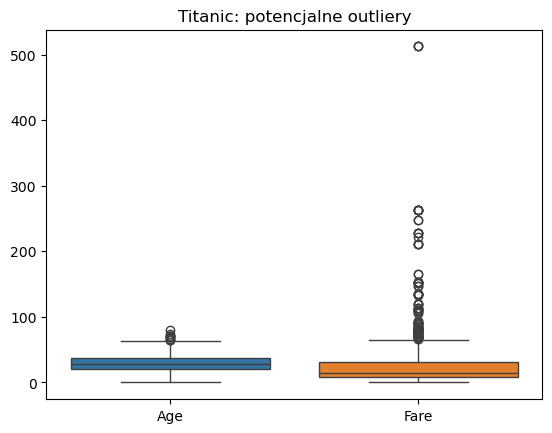

In [121]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(data=X[["Age", "Fare"]])
plt.title("Titanic: potencjalne outliery")
plt.show()

#### Procentu braków w każdej kolumnie
Przed budową modelu musimy zdecydować:
- czy usuwamy kolumnę?
- czy imputujemy?
- czy traktujemy jako specjalną kategorię?

In [125]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2 , random_state = 42, stratify=y)

# random_state Zapewnia powtarzalność losowania , za każdym razem podział bedzie indentyczny.
# stratify oznacza - rozwarstiwać // dzieki temu zachowuja proporcje klas (0,1) w obu zbiorach)

# poniższe printy maja sprawdzic proporcje klas, czy sa wiarygodne 
print('Traing positive rate: ',y_train.mean().round(3))
print('Test positive rate: ',y_test.mean().round(3))

Traing positive rate:  0.383
Test positive rate:  0.385


Po wykonaniu kodu mamy:
- X_train
- X_test
- y_train
- y_test

czyli dane gotowe do:
- imputacji
- skalowania
- kodowania
- budowy modelu

#### Preprocesing

In [139]:
from sklearn.compose import ColumnTransformer
# pozwala stosować różne transformacje do różnych kolumn w zbiorze danych.
# Pozwala:
# wybrać konkretne kolumny,
# przypisać im odpowiednie transformacje,
# połączyć wszystko w jeden przekształcony zbiór danych.
# Dzięki temu możesz:
# ✔ skalować kolumny numeryczne
# ✔ kodować kolumny kategoryczne
# ✔ usuwać wybrane kolumny
# ✔ zostawiać niektóre bez zmian

from sklearn.pipeline import Pipeline
# pozwala połączyć wiele kroków przetwarzania danych oraz model w jeden spójny obiek


from sklearn.preprocessing import OneHotEncoder ,StandardScaler 
# OneHot... -> podział kategorycznych wyników na [0,1] wartosci np male/felamle 0/1.
# Standa... -> do oblicznie z-wartości krytyczne na rozkładzie normalnym 

from sklearn.impute import SimpleImputer
# o klasa ze scikit-learn, służąca do uzupełniania brakujących wartości (NaN) w danych.

In [161]:
num_features = X_train.select_dtypes(include='number').columns
cat_features = X_train.select_dtypes(exclude='number').columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features),
    ],
    remainder='drop',
    verbose_feature_names_out=False
                    )

print('Num features: ', list(num_features))
print('Cat features: ', list(cat_features))

Num features:  ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Cat features:  ['Sex', 'Embarked']


,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

In [165]:
from sklearn.linear_model import LogisticRegression

clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('logreg', LogisticRegression(max_iter=2000))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
y_proba = clf.predict_proba(X_test)[:,1]

print('Model Wytrenowany')

Model Wytrenowany
